In [74]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sympy import *
import mtcnn
import cv2
from mtcnn.mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
#Libraries to evaluate the face recognition system's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Part 1: Dataset Selection and Preprocessing (15 points)

#### Testing pre-processing and face detection on one file

Set the default image dimensions

In [2]:
nrows = 64
ncolumns = 64

Specify the directory with the Yale faces

In [30]:
yalesfaces_dir = 'yalefaces'

#### Setup the dataset into training and testing data

Load the file data into different lists

In [3]:
subject_numbers = []
file_names = []
categories  = []
# Get the list of filenames
for file in os.listdir(yalefaces_dir):
    # Add the subject number, filename and category to seperate lists
    file_names.append(file)
    categories.append(file.split(".")[1])
    subject_numbers.append(file.split(".")[0].replace('subject0','').replace('subject',''))

Create a pandas DataFrame from the lists

In [4]:
faces_dict = {'Subject':subject_numbers, 'Category':categories, 'File':file_names}
faces_df = pd.DataFrame(faces_dict, columns = ['Subject', 'Category','File'])
faces_df.head()

,Subject,Category,File
0,1,centerlight,subject01.centerlight
1,1,glasses,subject01.glasses
2,1,happy,subject01.happy
3,1,leftlight,subject01.leftlight
4,1,noglasses,subject01.noglasses


Set the sizes of the test and training datasets

In [5]:
training_set_count = 8
class_count = len(faces_df["Subject"].unique())
dataset_size = faces_df["Category"].count()
test_size = 1 - (training_set_count * class_count / dataset_size)

Define the X and Y columns that will be used for testing and training

In [6]:
y = faces_df['Subject']
X = faces_df.drop('Subject', axis = 1)

X_train_info, X_test_info, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = 45, stratify = y)

Load the X_test and X_train data

In [31]:
def load_images_dataset(image_directory, dataset):
    face_images = []
    for filename in dataset["File"]:
        # Load the image from the directory as a PIL image
        image = Image.open(os.path.join(image_directory, filename))
        image = image.resize((nrows, ncolumns))
        face_images.append(np.asarray(image))
        
    return np.asarray(face_images)

In [32]:
X_test = load_images_dataset(yalesfaces_dir, X_test_info)
X_train = load_images_dataset(yalesfaces_dir, X_train_info)

Reshape and normalize the data

In [9]:
# Normalize the input vectors and labels
in_encoder = Normalizer(norm='l2')

# Reshape X_train into a 2D array using the dimensions of the 3D array
X_train_reshaped = X_train.reshape(X_train.shape[0],
                                   X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

# Reshape X_test into a 2D array using the dimensions of the 3D array
X_test_reshaped = X_test.reshape(X_test.shape[0],
                                 X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

#Normalize labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 4096)
Reshaped X_test (45, 4096)


LabelEncoder()

In [10]:
X_train.shape

(120, 64, 64)

### Part 2: Eigenface Generation (20 points)

Calculate the average face image

In [11]:
# Get the length of the images array
length_dataset = X_train_reshaped.shape[0]

mean_face = np.sum(X_train_reshaped, axis=0, dtype='float64') / length_dataset

Find the mean matrix using the numpy tile function. np.tile constructs an array by repeating a given dataset by the number of times specified

In [12]:
mean_matrix = np.tile(mean_face, (length_dataset, 1))

Mean-center the image data. Mean-centering calculates the difference between the mean value and the actual value, ensuring that we are only looking at the variance in the dataset

In [13]:
X_centered = X_train_reshaped - mean_matrix

Caclulate the co-variance in the data. Convariance is a measure of the relationship between two variables.

In this case, we calculate the co-variance by finding the dot product of the image data and a transposed version of the image data

In [14]:
covariance_matrix = (X_centered.dot(X_centered.T)) / length_dataset

Find the eigenvalues and eigenvectors using the covariance matrix. Because they are square and symmetrical, covariance matrixes are diagonalizable, which means an eigendecomposition can be performed on the matrix.

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Convert the eigenvalues and eigenvectors from complex numbers to real numbers

In [16]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

Find the order of the eignevalues

In [17]:
order = np.real(eigenvalues).argsort()[::-1]

Sort the eigenvalues by their order

In [18]:
eigenvalues = eigenvalues[order]

Get the principal components

In [19]:
eigenvectors_C = eigenvectors[:, order]

Project all images to the eigen space

In [20]:
eigenvectors_C = X_centered.T @ eigenvectors 

Normalize all the eigenfaces

In [21]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T)

Plot the first eigenface

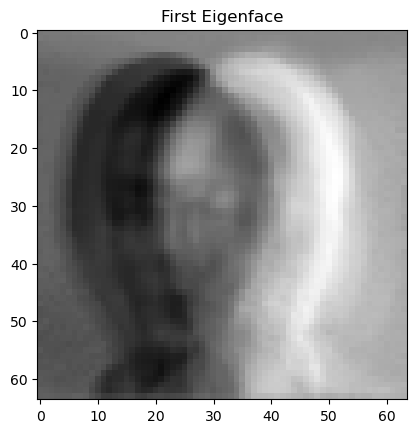

In [22]:
plt.imshow(np.resize(eigenfaces[0], (nrows,ncolumns)), cmap='gray')
plt.title('First Eigenface')
plt.show()

### Part 3: Face Recognition (35 points)

Create a function to project an image to the eigenspace

In [23]:
def project_to_eigenspace(image, eigen_faces, mean_face):
    return eigen_faces.dot(image - mean_face)

Create a function to find the cosine similarity between two matrices

In [24]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

Create a function to find the maximum similarity between an image projection and the set of eigen faces

In [25]:
def compute_max_similarity(image_projection, eigen_faces, num_components):
    eigen_projections = [project_to_eigenspace(ef, eigen_faces, mean_face) for ef in eigen_faces[:num_components]]
    similarities = [cosine_similarity(image_projection, ep) for ep in eigen_projections]
    
    return np.max(similarities)

Define a function to determine if an image contains a face

In [26]:
def is_face(image, eigen_faces, mean_face, num_components, threshold = 0.5):
    image_projection = project_to_eigenspace(image, eigen_faces, mean_face)
    max_similarity = compute_max_similarity(image_projection, eigen_faces[:num_components], num_components)
    return max_similarity > threshold

Check if an image is a face

In [28]:
given_image = Image.open('non_faces/B1_00107.pgm')
given_image = given_image.resize((nrows, ncolumns))
num_components = 5

# Convert the given image into a numpy array
given_image = np.asarray(given_image.getdata())

# Get the face evaluation result
result = is_face(given_image, eigenfaces[:num_components], mean_face, num_components)
if result:
    print("The image is a face")
else:
    print("The image is not a face")

The image is a face


Check the difference between the actual mean face and predicted mean faces

In [96]:
true_label = []
predicted_label = []

In [97]:
# Loop through the non-faces and faces
for i, image_file in enumerate(os.listdir(yalesfaces_dir)):
    # Label the file as a face
    true_label.append(1)
    new_image = Image.open(os.path.join(yalesfaces_dir, image_file))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

In [98]:
nonfaces_dir = 'non_faces'
# Loop through the non-faces and faces
for i, image_file in enumerate(os.listdir(nonfaces_dir)):
    # Label the file as a face
    true_label.append(0)
    new_image = Image.open(os.path.join(nonfaces_dir, image_file))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

Print the evaluation metrics

In [102]:
score = accuracy_score(true_label, predicted_label)
precision = precision_score(true_label, predicted_label)
recall = recall_score(true_label, predicted_label)
f1 = f1_score(true_label, predicted_label)
print(f"Accuracy score is {score}")
print(f"Precision score is {precision}")
print(f"Recall score is {recall}")
print(f"F1 score is {f1}")

Accuracy score is 0.2315369261477046
Precision score is 0.23684210526315788
Recall score is 0.6
F1 score is 0.339622641509434
